In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from d3pm_sc.ct_sched_cond import ScheduleCondition
from d3pm_sc.masking_diffusion import MaskingDiffusion
from d3pm_sc.d3pm_classic import D3PMClassic
from d3pm_sc.unet import KingmaUNet, UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama
from d3pm_sc import utils
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10

import wandb
wandb.login(key="6a47f093d2a55e4f4e85b33767423f2db66355b8")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alanamin. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/aa11803/.netrc


True

In [2]:
N = 256  # number of classes for discretized state per pixel
n_channel = 3
gamma = 0
hybrid_loss_coeff = 0.01
logistic_pars = False
fix_x_t_bias = False
lr = 2e-4
grad_clip_val = 1

s_dim = 4
conditional = False
forward_kwargs = {"type":"gaussian",
                  "normalized": True,
                  "bandwidth":1 / 7}

batch_size = 32
n_epoch = 14 * torch.cuda.device_count()

nn_params = {"n_channel": n_channel, 
             "N": N,
             "n_T": 500,
             "schedule_conditioning": True,
             "s_dim":4,
             "num_classes":10 if conditional else 1,
             "inc_attn": False,
             "time_embed_dim": 128,
             # "n_transformers": 12,
             # "n_heads": 12,
             # "ch": 256,
            }
x0_model_class = KingmaUNet

# x0_model_class = DiT_Llama
# nn_params['dim'] = 1024

##### Pick model
# Schedule conditioning
model = ScheduleCondition(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=hybrid_loss_coeff, gamma=gamma,
                          forward_kwargs=forward_kwargs, logistic_pars=logistic_pars, fix_x_t_bias=fix_x_t_bias, lr=lr, grad_clip_val=grad_clip_val)

# # # Masking
# nn_params["N"] += 1
# nn_params["schedule_conditioning"] = False
# model = MaskingDiffusion(x0_model_class, nn_params, num_classes=N, hybrid_loss_coeff=0.01).cuda()


##### Load data
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
def collate_fn(batch):
    x, cond = zip(*batch)
    x = torch.stack(x)
    cond = torch.tensor(cond)
    cond = (cond * conditional)
    x = (x * (N - 1)).round().long().clamp(0, N - 1)
    return x, cond
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=15, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=15, collate_fn=collate_fn)


Files already downloaded and verified


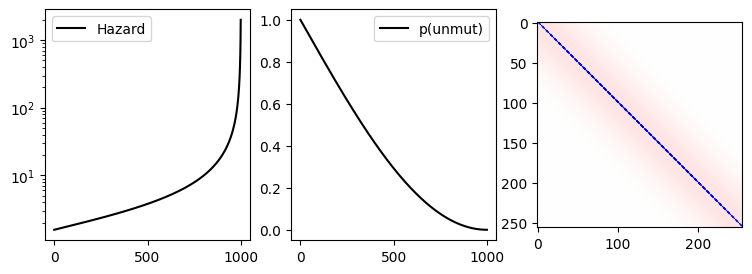

In [3]:
steps = torch.arange(1000 + 1, dtype=torch.float64) / 1000

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].semilogy(model.beta(steps), label="Hazard", color='black')
ax[0].legend()

alpha_bar = torch.exp(model.log_alpha(steps))
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

L = utils.get_inf_gens(forward_kwargs, N)
ax[2].imshow(L, vmin=-0.1, vmax=0.1, cmap='bwr')

In [4]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

wandb.init()
wandb_logger = WandbLogger(project="debugging")
lightning_model = model
torch.set_float32_matmul_precision('high')

# from pytorch_lightning.profilers import PyTorchProfiler
# profiler = PyTorchProfiler(
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log'),
#     schedule=torch.profiler.schedule(wait=1, warmup=1, active=10, repeat=2)
# )
trainer = Trainer(max_epochs=n_epoch, accelerator='auto',
                  devices=torch.cuda.device_count(), logger=wandb_logger)#, profiler=profiler)
trainer.fit(lightning_model, dataloader, test_dataloader)

/vast/aa11803/miniconda3/envs/evodiff/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /vast/aa11803/miniconda3/envs/evodiff/lib/python3.8 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/vast/aa11803/miniconda3/envs/evodiff/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/vast/aa11803/miniconda3/envs/evodiff/lib/python3.8/site-packages/pytorch_lightning/core/optimizer.py:377: Found unsupported keys in the optimizer configuration: {'gradient_clip_algorithm', 'gr

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

W0910 08:40:29.176383 140372885997376 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] q1 is not in var_ranges, defaulting to unknown range.
W0910 08:40:29.271532 140372885997376 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] z1 is not in var_ranges, defaulting to unknown range.
W0910 08:40:36.927466 140372885997376 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] y0 is not in var_ranges, defaulting to unknown range.


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 GiB. GPU 0 has a total capacity of 44.48 GiB of which 19.66 GiB is free. Including non-PyTorch memory, this process has 24.82 GiB memory in use. Of the allocated memory 24.62 GiB is allocated by PyTorch, and 12.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

import wandb
wandb.finish()

In [ ]:
a = [np.array(p.shape) for p in model.x0_model.down_blocks[0][0].parameters()]

In [ ]:
print(sum([np.prod(p) for p in a]))
print(a)

In [ ]:
31470288 - (17884416 + 11563008) * (1-48/64)